In [1]:
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)
from tomoSegmentPipeline.losses import Tversky_loss

from tomoSegmentPipeline.utils.common import read_array


PARENT_PATH = setup.PARENT_PATH

import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import pandas as pd

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
train_tomos = ['tomo02', 'tomo03', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo32', 'tomo10']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38', 'tomo04']
concat_test_ids = sorted([s.replace('tomo', '') for s in test_tomos])
concat_test_ids = '-'.join(concat_test_ids)

path_data, path_target = setup.get_paths_cryoCARE(train_tomos)

In [3]:
paths_trainData, paths_trainTarget = setup.get_paths(train_tomos, 'cryoCARE')
paths_valData, paths_valTarget = setup.get_paths(val_tomos, 'cryoCARE')

paths_trainData[0:1], paths_trainTarget[0:1]

(['/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/imagesTr/tomo02_patch000_0000.nii.gz'],
 ['/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/labelsTr/tomo02_patch000.nii.gz'])

# Tversky 01 loss

## Minimum working example

In [143]:
batch_size = 5
Nclass_labels = 3
coords_flat = 4

a = torch.rand((batch_size, Nclass_labels, coords_flat))
a

tensor([[[0.6236, 0.4379, 0.7707, 0.3641],
         [0.4883, 0.3894, 0.7406, 0.4208],
         [0.2119, 0.4471, 0.2656, 0.9559]],

        [[0.6059, 0.9446, 0.4042, 0.4644],
         [0.8206, 0.2262, 0.3832, 0.8631],
         [0.9738, 0.8304, 0.8016, 0.8183]],

        [[0.9502, 0.6654, 0.9127, 0.7850],
         [0.5821, 0.3297, 0.6201, 0.1419],
         [0.0774, 0.0836, 0.1705, 0.8434]],

        [[0.7950, 0.6530, 0.9937, 0.9242],
         [0.1492, 0.5924, 0.1601, 0.2830],
         [0.9210, 0.1545, 0.0786, 0.3558]],

        [[0.7233, 0.5092, 0.0064, 0.1323],
         [0.5462, 0.4583, 0.1801, 0.5549],
         [0.9234, 0.6895, 0.1388, 0.7879]]])

In [149]:
z_shape = a.shape[2]
z_shape

4

In [150]:
b = a[:, 2, :]>0.7
b = b.reshape(batch_size, 1, z_shape)
b

tensor([[[False, False, False,  True]],

        [[ True,  True,  True,  True]],

        [[False, False, False,  True]],

        [[ True, False, False, False]],

        [[ True, False, False,  True]]])

In [152]:
c = a[:, 0:2, :,]
c

tensor([[[0.6236, 0.4379, 0.7707, 0.3641],
         [0.4883, 0.3894, 0.7406, 0.4208]],

        [[0.6059, 0.9446, 0.4042, 0.4644],
         [0.8206, 0.2262, 0.3832, 0.8631]],

        [[0.9502, 0.6654, 0.9127, 0.7850],
         [0.5821, 0.3297, 0.6201, 0.1419]],

        [[0.7950, 0.6530, 0.9937, 0.9242],
         [0.1492, 0.5924, 0.1601, 0.2830]],

        [[0.7233, 0.5092, 0.0064, 0.1323],
         [0.5462, 0.4583, 0.1801, 0.5549]]])

In [153]:
i = torch.stack(2*[b], dim=1).squeeze()*1
i.shape

torch.Size([5, 2, 4])

In [154]:
c*i

tensor([[[0.0000, 0.0000, 0.0000, 0.3641],
         [0.0000, 0.0000, 0.0000, 0.4208]],

        [[0.6059, 0.9446, 0.4042, 0.4644],
         [0.8206, 0.2262, 0.3832, 0.8631]],

        [[0.0000, 0.0000, 0.0000, 0.7850],
         [0.0000, 0.0000, 0.0000, 0.1419]],

        [[0.7950, 0.0000, 0.0000, 0.0000],
         [0.1492, 0.0000, 0.0000, 0.0000]],

        [[0.7233, 0.0000, 0.0000, 0.1323],
         [0.5462, 0.0000, 0.0000, 0.5549]]])

In [132]:
r = c.gather(1, i).squeeze()
r

tensor([[[[[0.3406, 0.3141, 0.4337, 0.9817],
           [0.7758, 0.2155, 0.0186, 0.7894],
           [0.2678, 0.8539, 0.4226, 0.2377],
           [0.9148, 0.9197, 0.2613, 0.4988]],

          [[0.0528, 0.6017, 0.2385, 0.3014],
           [0.3375, 0.7155, 0.9946, 0.5770],
           [0.7795, 0.6742, 0.4797, 0.4267],
           [0.1640, 0.3129, 0.3724, 0.7945]],

          [[0.3322, 0.3323, 0.3397, 0.9541],
           [0.6410, 0.2763, 0.7360, 0.6409],
           [0.6264, 0.2954, 0.9229, 0.4287],
           [0.4882, 0.8383, 0.9058, 0.1280]],

          [[0.8949, 0.7210, 0.1967, 0.1467],
           [0.6214, 0.7596, 0.4724, 0.2517],
           [0.8196, 0.3415, 0.5108, 0.0438],
           [0.2808, 0.5492, 0.9526, 0.1998]]],


         [[[0.3406, 0.3141, 0.4337, 0.9817],
           [0.7758, 0.2155, 0.0186, 0.7894],
           [0.2678, 0.8539, 0.4226, 0.2377],
           [0.9148, 0.9197, 0.2613, 0.4988]],

          [[0.0528, 0.6017, 0.2385, 0.3014],
           [0.3375, 0.7155, 0.9946, 0.5770]

In [117]:
a = torch.rand((264, 2, 3))
b = torch.randint(0, 2, (264,))
i = torch.stack(3*[b], dim=1).view(-1, 1, 3)
r = a.gather(1, i).squeeze()
r.shape

torch.Size([264, 3])

## Modified Tversky

In [4]:
# model expects inputs of shape (n_batch, Nclass, Z, Y, X)
class Tversky_loss(torch.nn.Module):
    def __init__(self):
        super(Tversky_loss, self).__init__()

    def forward(self, y_pred, y_true):
        # alpha = torch.Tensor([0.5], device=('cuda' if torch.cuda.is_available() else 'cpu)')
        # the case of α = β = 0.5 the Tversky index simplifies to be the same as the Dice coefficient
        
        # set everything to the same device
        y_true = y_true.type_as(y_pred)
        
        alpha = torch.empty((1)).type_as(y_true)
        alpha[0] = 0.5
        beta = torch.empty((1)).type_as(y_true)
        beta[0] = 0.5

        # only classes 0 and 1 are taken into account for the loss      
        batch_size, _, z_shp, y_shp, x_shp = y_true.shape 

        mask = y_true[:, 2, :, :, :]!=1
        mask = mask.reshape(batch_size, 1, z_shp, y_shp, x_shp)
        mask = torch.stack(2*[mask], dim=1).squeeze(2)*1
        
        # we set all the coordinates labelled as 2 to zero for the loss
        y_true = y_true[:, 0:2, :, :, :]*mask
        y_pred = y_pred[:, 0:2, :, :, :]*mask
        
        ones = torch.ones_like(y_true)
        p0 = y_pred
        p1 = (ones - y_pred)
        g0 = y_true
        g1 = (ones - y_true)

        num = torch.sum(p0 * g0, dim=(0, 2, 3, 4)) # shape of inputs are (batch_size, N_class, Z, Y, X)
        den = num + alpha * torch.sum(p0 * g1, dim=(0, 2, 3, 4)) + beta * torch.sum(p1 * g0, dim=(0, 2, 3, 4))

        # Here we are getting the total tversky index for all classes that's why we return Ncl-T
        T = torch.sum(num / den)

        # Ncl = torch.Tensor(y_true.shape[-1])
        Ncl = torch.empty((1)).type_as(y_true)
        Ncl[0] = y_true.shape[1]
        return Ncl - T

In [5]:
dim_in = 160
Lrnd = 5

# my_dataset = dl.tomoSegment_dataset(path_data, path_target, dim_in, Ncl=2, Lrnd=Lrnd, augment_data=False)
my_dataset = dl.tomoSegment_dummyDataset(paths_valData[0:1], paths_valTarget[0:1], dim_in, Ncl=2)
len(my_dataset)

1

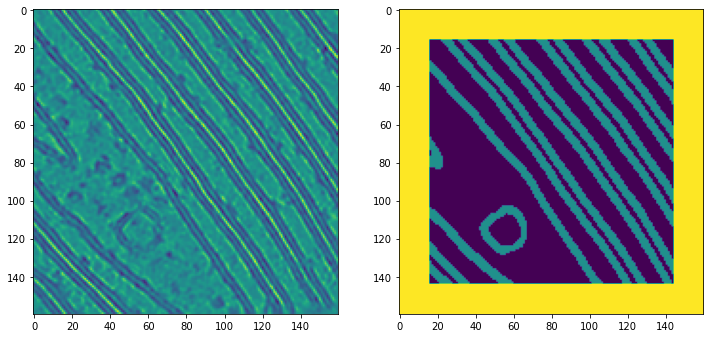

In [6]:
batch_data, batch_target = my_dataset[0]

aux_target = batch_target.argmax(0)
aux_data = batch_data.squeeze()


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 10))
ax1.imshow(aux_data[dim_in//2])
ax2.imshow(aux_target[dim_in//2])

In [7]:
# model_file = os.path.join(PARENT_PATH, 'models_scratchpad/logs/LowBaselineModel/train02/version_0/3.00_lowBaseline_ep500_in84_lr0.000100_0.model')
model_file = os.path.join(PARENT_PATH, 'models_scratchpad/logs/BaselineModel/train02-03-17/version_1/3.00_Baseline_ep500_in84_lr0.000100_1.model')
model = load_model(model_file, 2)
y_pred = model(batch_data.unsqueeze(0))
y_true = batch_target.unsqueeze(0)

y_true.shape, y_pred.shape

(torch.Size([1, 3, 160, 160, 160]), torch.Size([1, 2, 160, 160, 160]))

In [19]:
y_pred = y_pred.cuda()

In [20]:
%%timeit
loss = Tversky_loss()
loss(y_pred, y_true)

9.92 ms ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
loss = Tversky_loss()
loss(y_pred, y_true)

tensor([0.0551], device='cuda:0', grad_fn=<SubBackward0>)

In [22]:
from tomoSegmentPipeline.losses import Tversky_loss as Tversky_loss2

In [23]:
y_true = y_true.type_as(y_pred)

In [24]:
%%timeit
loss = Tversky_loss2()
loss(y_pred, y_true)

4.27 ms ± 513 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
loss = Tversky_loss2()
loss(y_pred, y_true)

tensor([0.0551], device='cuda:0', grad_fn=<SubBackward0>)

In [35]:
loss = Tversky_loss2()
loss(y_true, y_true)

tensor([0.], device='cuda:0')

In [51]:
aux = torch.randint(0, 2, y_true.shape)
aux.shape

torch.Size([1, 3, 160, 160, 160])

In [54]:
y_check_true = aux
y_check_pred = aux[:, 0:2, :, :]

# If we start with two equal tensors, and change the values of the true one in the last channel, nothing should change: good
# y_check_true[:, 2, 0:15, 0:15, 0:15] = 1
# y_check_true[:, 2, 100:122, 25:30, 33:70] = 1

print(y_check_true.shape, y_check_pred.shape)

loss = Tversky_loss2()
loss(y_check_pred.cuda(), y_check_true.cuda())

torch.Size([1, 3, 160, 160, 160]) torch.Size([1, 2, 160, 160, 160])


tensor([0.], device='cuda:0')

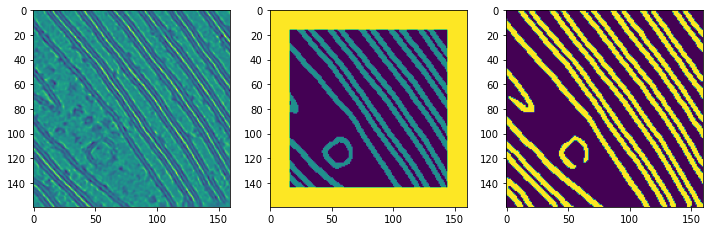

In [13]:
batch_data, batch_target = my_dataset[0]

aux_target = batch_target.argmax(0)
aux_data = batch_data.squeeze()


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 10))
ax1.imshow(aux_data[dim_in//2])
ax2.imshow(aux_target[dim_in//2])
ax3.imshow(y_pred.squeeze().argmax(0).cpu()[dim_in//2])

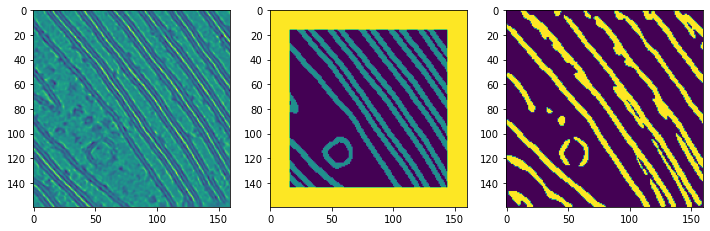

In [42]:
batch_data, batch_target = my_dataset[0]

aux_target = batch_target.argmax(0)
aux_data = batch_data.squeeze()


fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 10))
ax1.imshow(aux_data[dim_in//2])
ax2.imshow(aux_target[dim_in//2])
ax3.imshow(y_pred.squeeze().argmax(0).cpu()[dim_in//2])

# Try the loss on model

In [4]:
paths_trainData, paths_trainTarget = setup.get_paths([t for t in tomo_ids if t[0:6] in train_tomos])
paths_valData, paths_valTarget = setup.get_paths([t for t in tomo_ids if t[0:6] in val_tomos])

In [5]:
paths_trainData[0:1], paths_trainTarget[0:1]

(['/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/imagesTr/tomo02_patch000_0000.nii.gz'],
 ['/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/labelsTr/tomo02_patch000.nii.gz'])

In [8]:
tb_logdir = os.path.join(PARENT_PATH, 'models_scratchpad/logs/BaselineModelTestRun/train%s' %concat_train_ids)

trainer = make_trainer(dim_in=160, batch_size=1, lr=1e-4, epochs=500, tb_logdir=tb_logdir, model_name='3.00_BaselineTestRun',
                       reconstruction_trainer=False, pretrained_model=None, test_run=True)

In [9]:
trainer.launch(paths_trainData[0:1], paths_trainTarget[0:1], paths_trainData[0:1], paths_trainTarget[0:1], dl.tomoSegment_dummyDataset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Set SLURM handle signals.

  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | Tversky_loss | 0     
1 | layer1  | Sequential   | 28.6 K
2 | layer2  | Sequential   | 103 K 
3 | layer3  | Sequential   | 558 K 
4 | layer4  | Sequential   | 288 K 
5 | layer5  | Sequential   | 96.9 K
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.304     Total estimated model params size (MB)


"Ncl":           2
"loss_fn":       Tversky_loss()
"lr":            0.0001
"pretrain_type": None
"weight_decay":  0.0
Saving model at:  /home/haicu/jeronimo.carvajal/Thesis/models_scratchpad/logs/BaselineModelTestRun/train02-03-17/version_0/3.00_BaselineTestRun_ep500_in160_lr0.000100_0.model

Writing to modelSummary...
Opening ModelSummary file...
No file found, writing header and row_data...


In [41]:
trainer.model_name

'3.00_BaselineTestRun'

In [24]:
def fullTomogram_modelComparison2(model_fileList, n_centers_list, tomo_file, label_file, is_model_data=True):
    
    tomogram_data, classes = load_tomoData(tomo_file, label_file, is_model_data)

    z, y, x = tomogram_data.shape

    classes = torch.tensor(classes)
    Nclass_data = int(classes.max()+1)


    classes = transpose_to_channels_first(to_categorical(classes, num_classes=Nclass_data))

    y_true = torch.zeros((1, Nclass_data, z, y, x))
    y_true[0, :, :, :, :] = classes

    weight_decay = 0

    class_predDict = {}
    dice1_dict = {}

    for model_file, n_centers in zip(model_fileList, n_centers_list):
        Nclass_model = 2
        model = load_model(model_file,  Nclass_model, weight_decay)
        model_name = model_file.split('/')[-1].replace('.model', '')

        dim_in = int(model_file.split('in')[-1].split('_')[0])
        
        class_pred = predict_fullTomogram(tomogram_data, model, dim_in, n_centers, Nclass_model)
        print('Saving model predictions...')
        save_classPred(class_pred, model_name, tomo_file, True)

        class_predDict[model_name] = class_pred

        y_pred = torch.zeros((1, Nclass_model, z, y, x))
        y_pred[0, :, :, :, :] = transpose_to_channels_first(to_categorical(class_pred, Nclass_model))
        
        Nclass = min(Nclass_data, Nclass_model)

        dice1 = Tversky_index(y_pred, y_true)
        dice1_dict[model_name] = dice1

    tomo_name = tomo_file.split('/')[-1]
    
    return class_predDict, dice1_dict, classes, tomogram_data

In [37]:
model_fileList = [os.path.join(PARENT_PATH, 'models_scratchpad/logs/BaselineModelTestRun/train02-03-17/version_0/3.00_BaselineTestRun_ep500_in160_lr0.000100_0.model')]
n_centersList = [1]

tomo_file, label_file = paths_trainData[0], paths_trainTarget[0]


class1_predDict, dice1_dict, classes, tomogram_data = fullTomogram_modelComparison2(model_fileList, n_centersList, tomo_file, label_file)

Tomogram shape:  (160, 160, 160)
Predicting full tomogram using 1 centers...


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Saving model predictions...


In [38]:
y_pred = class1_predDict['3.00_BaselineTestRun_ep500_in160_lr0.000100_0']
y_pred = transpose_to_channels_first(to_categorical(y_pred)).unsqueeze(0).to('cuda')

y_real = read_array(label_file)
y_real = transpose_to_channels_first(to_categorical(y_real, num_classes=3)).unsqueeze(0).to('cuda')

y_pred.shape, y_real.shape

(torch.Size([1, 2, 160, 160, 160]), torch.Size([1, 3, 160, 160, 160]))

In [35]:
dice1_dict

{'3.00_BaselineTestRun_ep500_in160_lr0.000100_0': tensor([0.9920, 0.9649], device='cuda:0')}

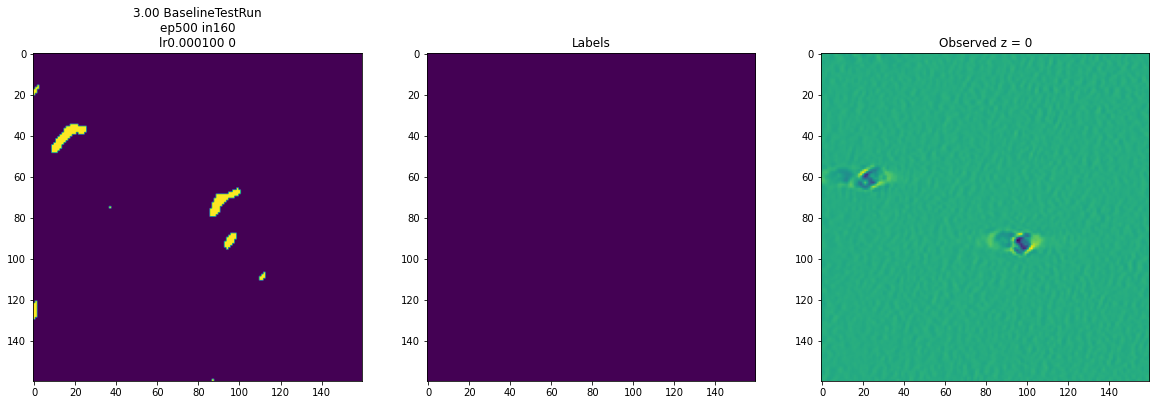

<Figure size 432x288 with 0 Axes>

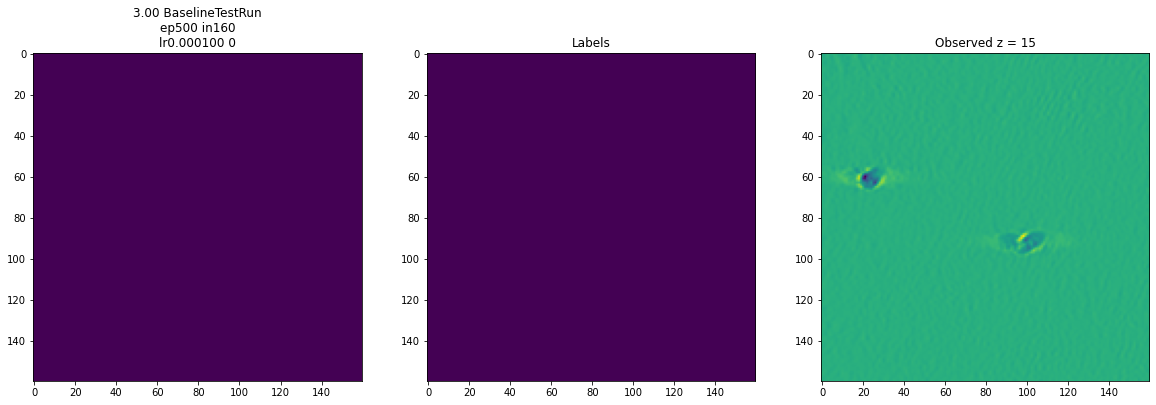

<Figure size 432x288 with 0 Axes>

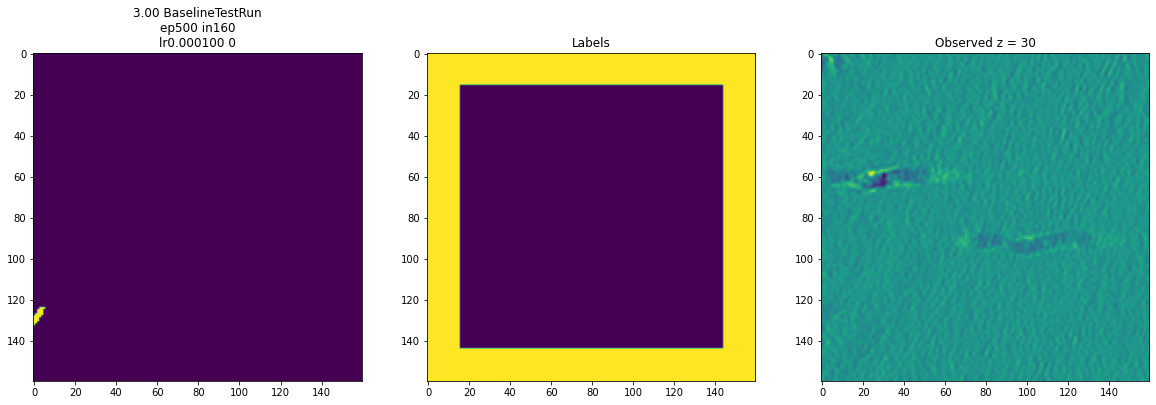

<Figure size 432x288 with 0 Axes>

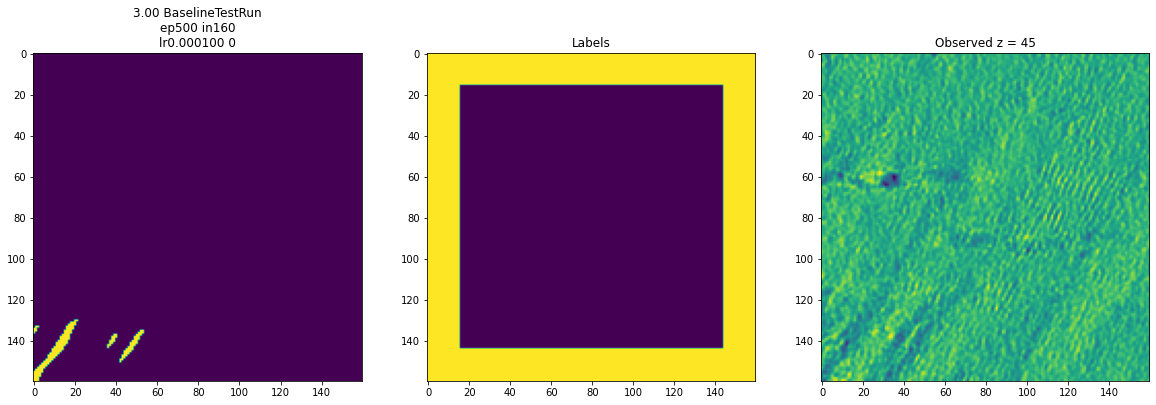

<Figure size 432x288 with 0 Axes>

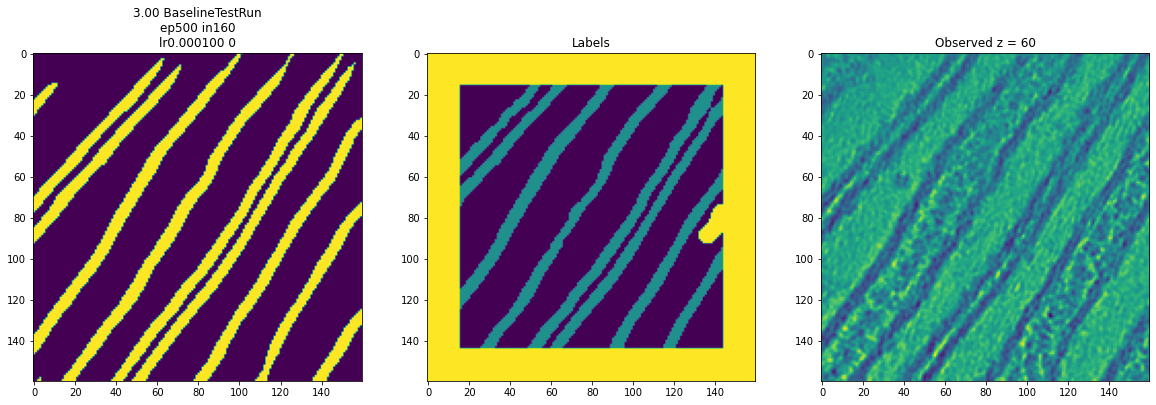

<Figure size 432x288 with 0 Axes>

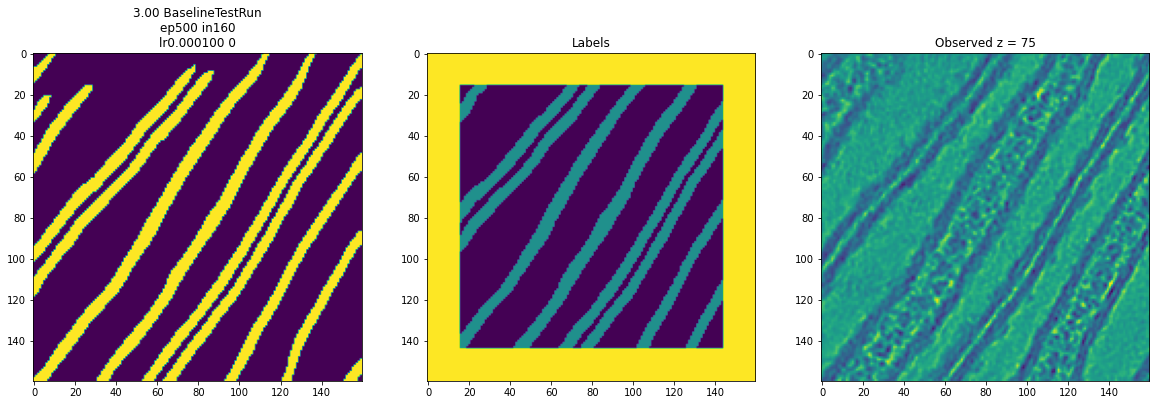

<Figure size 432x288 with 0 Axes>

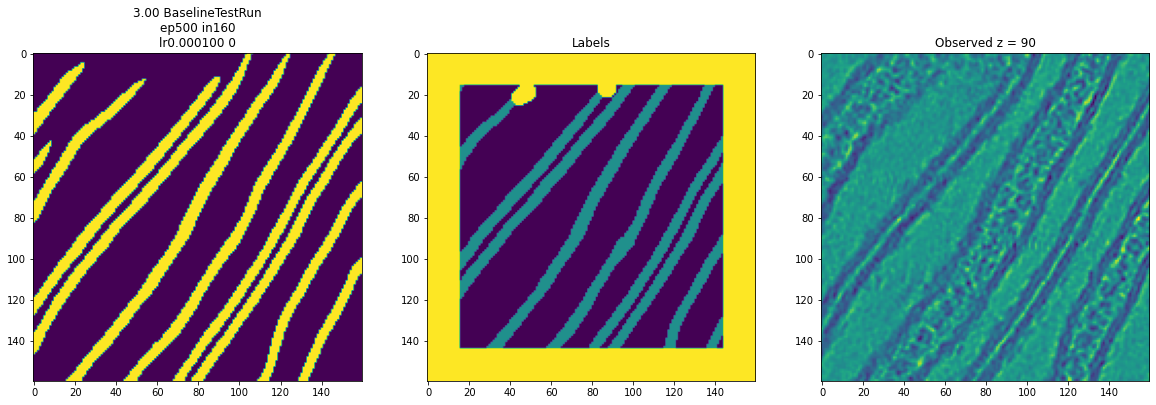

<Figure size 432x288 with 0 Axes>

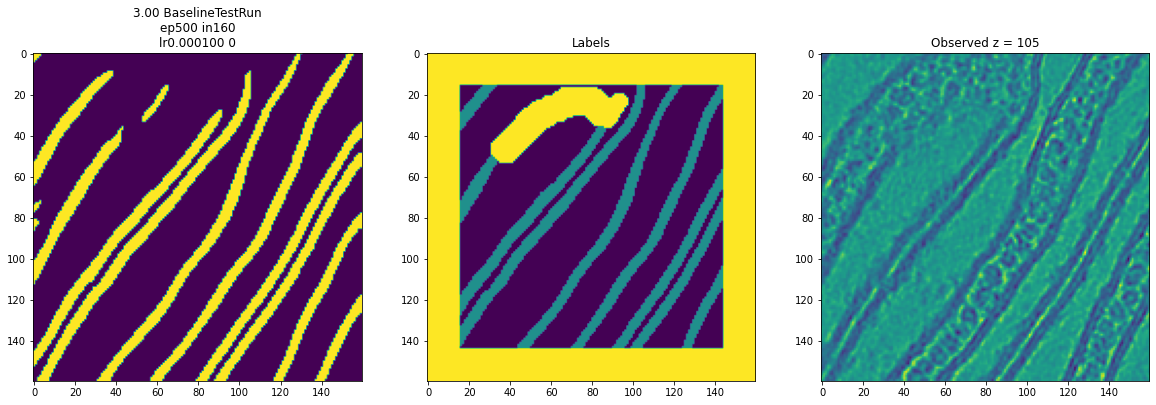

<Figure size 432x288 with 0 Axes>

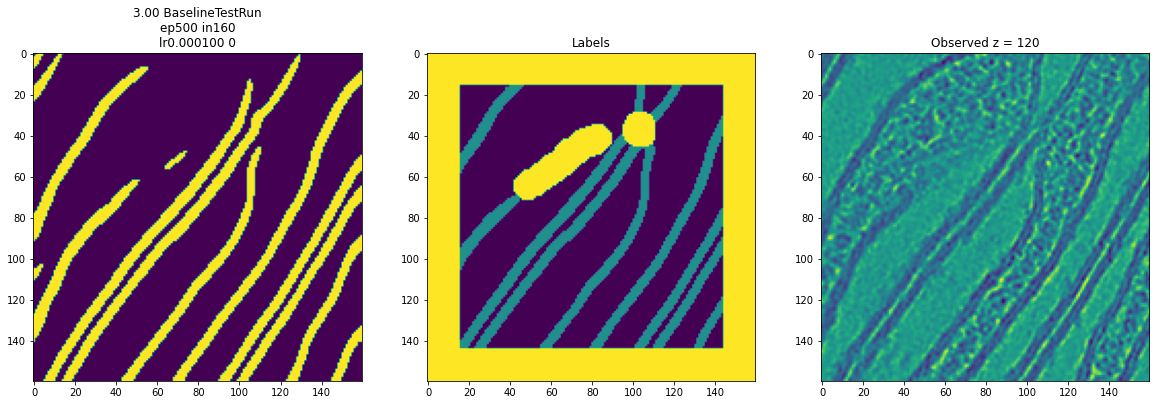

<Figure size 432x288 with 0 Axes>

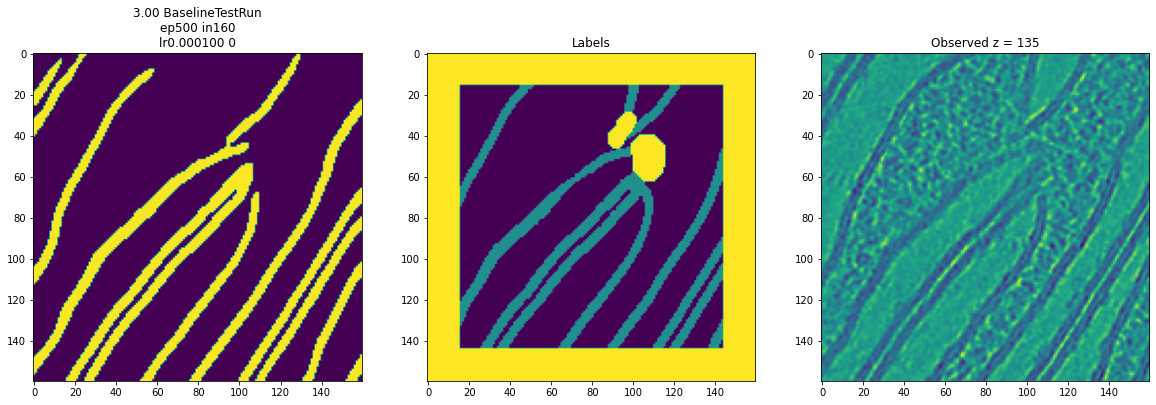

<Figure size 432x288 with 0 Axes>

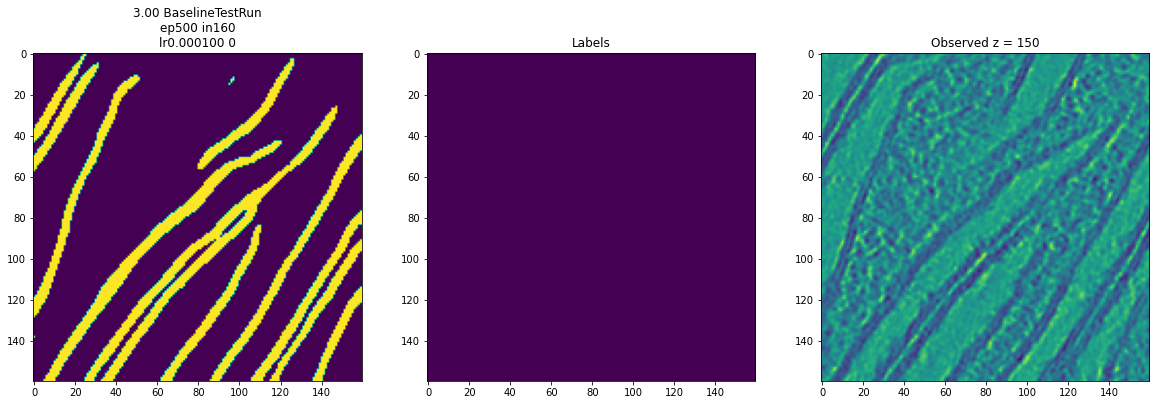

<Figure size 432x288 with 0 Axes>

In [36]:
make_comparison_plot(class1_predDict, classes, tomogram_data)